In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [14]:
mat = scipy.io.loadmat('notMNIST_small.mat')
mat.keys()


dict_keys(['__header__', '__version__', '__globals__', 'images', 'labels'])

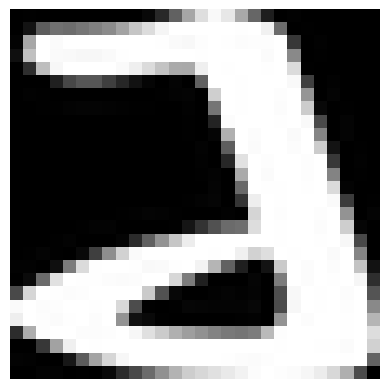

In [15]:
mat['images'].shape

plt.imshow(mat['images'][:, :, 1], cmap='gray')
plt.axis('off')
plt.show()

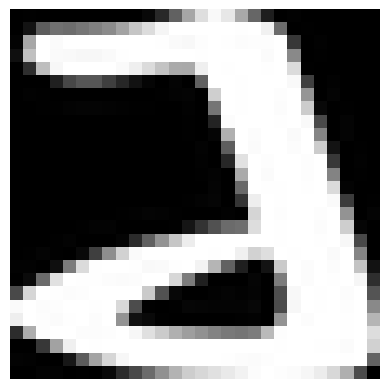

(18724, 28, 28)

In [16]:
new_img = np.random.rand(18724, 28, 28)
for index in range(mat['images'].shape[2]):
    new_img[index] = mat['images'][:,:,index]

plt.imshow(new_img[1, :, :], cmap='gray')
plt.axis('off')
plt.show()

new_img.shape

In [17]:
indices = np.arange(18724)
np.random.shuffle(indices)
labels = np.array(mat['labels'])


shuffled_images = new_img[indices]
shuffled_labels = labels[indices]

In [18]:
x_train_img = np.array(shuffled_images[0:11234, :,:])
x_test_img = np.array(shuffled_images[11235:18724, :,:])
y_train_label = np.array(shuffled_labels[0:11234])
y_test_label =np.array(shuffled_labels[11235:18724])

x_train_img.shape

(11234, 28, 28)

In [19]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):

        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [20]:
test_images = x_test_img
test_labels = y_test_label

test_dataset = CustomDataset(test_images, test_labels)

test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [21]:
from torch.utils.data import DataLoader


images = x_train_img
labels = y_train_label

custom_dataset = CustomDataset(images, labels)


data_loader = DataLoader(dataset=custom_dataset, batch_size=32, shuffle=True)


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):  
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  #(28/2/2 = 7)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x1 = self.pool(F.relu(self.conv1(x)))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = x2.view(-1, 64 * 7 * 7)
        x4 = F.relu(self.fc1(x3))
        out = self.fc2(x4)
        return x1, x2, x3, x4, out

C:\Users\denis\AppData\Local\Temp\ipykernel_15428\3440450615.py:22: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1/25, Step 100/352, Loss: 0.07032
Epoch 1/25, Step 200/352, Loss: 0.17281
Epoch 1/25, Step 300/352, Loss: 0.91409
Epoch 2/25, Step 100/352, Loss: 0.26282
Epoch 2/25, Step 200/352, Loss: 0.19874
Epoch 2/25, Step 300/352, Loss: 0.25168
Epoch 3/25, Step 100/352, Loss: 0.34915
Epoch 3/25, Step 200/352, Loss: 0.26704
Epoch 3/25, Step 300/352, Loss: 0.10944
Epoch 4/25, Step 100/352, Loss: 0.07963
Epoch 4/25, Step 200/352, Loss: 0.19690
Epoch 4/25, Step 300/352, Loss: 0.11577
Epoch 5/25, Step 100/352, Loss: 0.19902
Epoch 5/25, Step 200/352, Loss: 0.15189
Epoch 5/25, Step 300/352, Loss: 0.01209
Epoch 6/25, Step 100/352, Loss: 0.02830
Epoch 6/25, Step 200/352, Loss: 0.04455
Epoch 6/25, Step 300/352, Loss: 0.14047
Epoch 7/25, Step 100/352, Loss: 0.05660
Epoch 7/25, Step 200/352, Loss: 0.04032
Epoch 7/25, Step 300/352, Loss: 0.07364
Epoch 8/25, Step 100/352, Loss: 0.13813
Epoch 8/25, Step 200/352, Loss: 0.10720
Epoch 8/25, Step 300/352, Loss: 0.08797
Epoch 9/25, Step 100/352, Loss: 0.03944


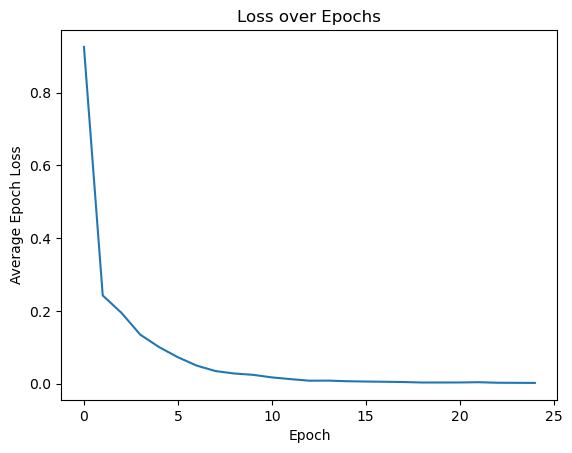

In [23]:
model_2 = SimpleCNN(num_classes=10) 
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.001, momentum=0.8)  

model_2 = model_2.to(device)

num_epochs = 25  
epoch_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0  
    num_batches = 0  

    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)
        
        _, _, _, _, outputs = model_2(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')

    epoch_loss /= num_batches
    epoch_losses.append(epoch_loss)

plt.plot(epoch_losses)
plt.ylabel('Average Epoch Loss')
plt.xlabel('Epoch')
plt.title('Loss over Epochs')
plt.show()


In [24]:
def test_model_2(model_2, test_loader):
    model_2 = model_2.to(device)
    
    model_2.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            images = images.unsqueeze(1)  
            _, _, _, _,outputs = model_2(images)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


test_model_2(model_2, test_loader)

C:\Users\denis\AppData\Local\Temp\ipykernel_15428\3440450615.py:22: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Accuracy: 93.80%


C:\Users\denis\AppData\Local\Temp\ipykernel_15428\3440450615.py:22: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


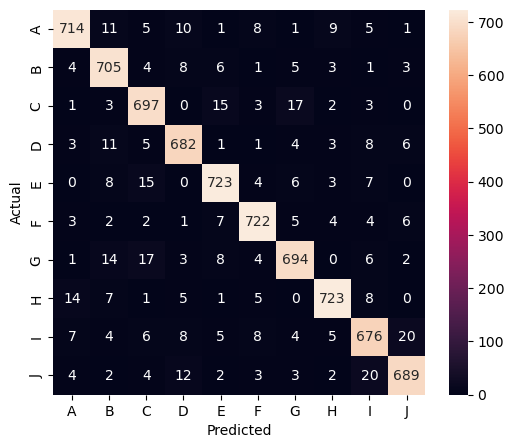

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def get_all_preds_and_labels(model, loader, device):
    all_preds = []
    all_labels = []
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)
        _, _, _, _, outputs = model(images) 
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_preds, axis=0), np.concatenate(all_labels, axis=0)

def plot_confusion_matrix(model, loader, device, class_names):
    preds, labels = get_all_preds_and_labels(model, loader, device)
    cm = confusion_matrix(labels, preds)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plot_confusion_matrix(model_2, test_loader, device, class_names)

In [25]:


class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512*2)
        self.fc3 = nn.Linear(512*2, 512)
        self.fc4 = nn.Linear(512, 10)    
        self.dropout = nn.Dropout2d(p=0.2)


    def forward(self, x):
        x = x.view(-1, 28 * 28)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.dropout(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.dropout(x))
        x = self.fc4(x)
        return x


In [26]:
model = SimpleNN() 
model = model.to(device)
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  


num_epochs = 20  

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')



C:\Users\denis\AppData\Local\Temp\ipykernel_15428\3440450615.py:22: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)
c:\Users\denis\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/20, Step 100/352, Loss: 0.68005
Epoch 1/20, Step 200/352, Loss: 0.35035
Epoch 1/20, Step 300/352, Loss: 0.73694
Epoch 2/20, Step 100/352, Loss: 0.59989
Epoch 2/20, Step 200/352, Loss: 0.30360
Epoch 2/20, Step 300/352, Loss: 0.90763
Epoch 3/20, Step 100/352, Loss: 0.59594
Epoch 3/20, Step 200/352, Loss: 0.59593
Epoch 3/20, Step 300/352, Loss: 0.37110
Epoch 4/20, Step 100/352, Loss: 0.21246
Epoch 4/20, Step 200/352, Loss: 0.71483
Epoch 4/20, Step 300/352, Loss: 0.24770
Epoch 5/20, Step 100/352, Loss: 0.71051
Epoch 5/20, Step 200/352, Loss: 0.24707
Epoch 5/20, Step 300/352, Loss: 0.04784
Epoch 6/20, Step 100/352, Loss: 0.25283
Epoch 6/20, Step 200/352, Loss: 0.34262
Epoch 6/20, Step 300/352, Loss: 0.33855
Epoch 7/20, Step 100/352, Loss: 0.12770
Epoch 7/20, Step 200/352, Loss: 0.43427
Epoch 7/20, Step 300/352, Loss: 0.60286
Epoch 8/20, Step 100/352, Loss: 0.43837
Epoch 8/20, Step 200/352, Loss: 0.26730
Epoch 8/20, Step 300/352, Loss: 0.38665
Epoch 9/20, Step 100/352, Loss: 0.15182


In [27]:
def test_model(model, test_loader):
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for images, labels in test_loader:
            images = images.unsqueeze(1)  
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


test_model(model, test_loader)

C:\Users\denis\AppData\Local\Temp\ipykernel_15428\3440450615.py:22: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Accuracy: 89.56%
